In [128]:
import pandas as pd
import pickle
import yaml

tic = 29923559

data = pickle.load(
    open(
        f"../data/{tic}/cleaned_lc.fluxes",
        "rb",
    )
)
df = pd.read_csv(f"../data/{tic}/search_results.csv")
gp_params = yaml.full_load(
    open(
        f"../data/{tic}/gp.yaml",
        "rb",
    )
)

tls, nuance, radii, periods, tau, delta = (
    df["tls_found"].values,
    df["nuance_found"].values,
    df["planet_radius"].values,
    df["planet_period"].values,
    df["tau"].values,
    df["delta"].values,
)

In [129]:
import numpy as np
from nuance.star import Star
import numpy as np

jitter = np.exp(gp_params["log_jitter"])
star = Star(
    data["star_radius"], data["star_mass"], data["star_amplitude"], data["star_period"]
)

unique_periods = np.unique(periods)
min_radii = star.min_radius(unique_periods, 6, len(data["time"]), jitter)


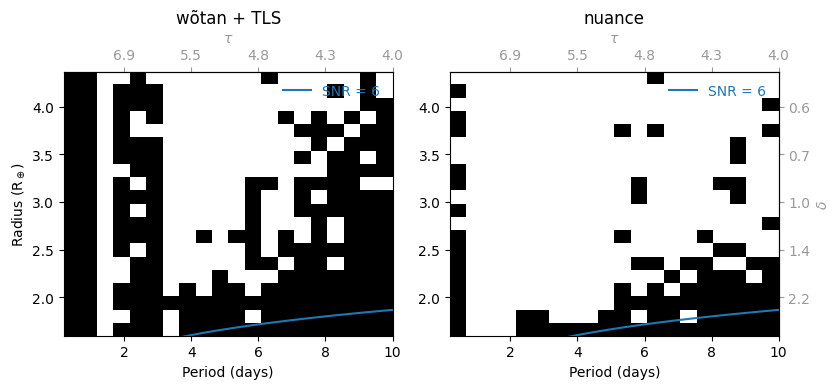

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# setting up ranges
taus_range = np.min(tau), np.max(tau)
deltas_range = np.min(delta), np.max(delta)
periods_range = np.min(periods), np.max(periods)
radii_range = np.min(radii), np.max(radii)
extent = (*periods_range, *radii_range)

# figure
fig = plt.figure(None, (8.5, 4))
sec_color = "0.6"

ax = plt.subplot(122)
plt.imshow(
    nuance.reshape(20, 20), extent=extent, origin="lower", aspect="auto", cmap="Greys_r"
)
plt.plot(unique_periods, min_radii, label="SNR = 6")
plt.xlim(periods_range)
plt.ylim(radii_range)
plt.xlabel("Period (days)")
ax.set_title("nuance")
# secondary axes
secax = ax.secondary_yaxis("right")
radii_ticks = ax.get_yticks()
delta_ticks = star.radius2delta(radii_ticks)
secax.set_yticks(radii_ticks, [f"{t:.1f}" for t in delta_ticks])
secax.set_ylabel(r"$\delta$", color=sec_color)
secax.tick_params(axis="y", colors=sec_color)

secax = ax.secondary_xaxis("top")
period_ticks = ax.get_xticks()
tau_ticks = star.period2tau(period_ticks)
secax.set_xticks(period_ticks, [f"{t:.1f}" for t in tau_ticks])
secax.set_xlabel(r"$\tau$", color=sec_color)
secax.tick_params(axis="x", colors=sec_color)
# legend with no background and text in blue
l = ax.legend(loc="upper right", frameon=False)
l.get_texts()[0].set_color("C0")

ax = plt.subplot(121)
plt.imshow(
    tls.reshape(20, 20), extent=extent, origin="lower", aspect="auto", cmap="Greys_r"
)
plt.plot(unique_periods, min_radii, label="SNR = 6")
plt.xlim(periods_range)
plt.ylim(radii_range)
plt.xlabel("Period (days)")
ax.set_title("wõtan + TLS")
plt.ylabel("Radius (R$_\oplus$)")
secax = ax.secondary_xaxis("top")
period_ticks = ax.get_xticks()
tau_ticks = star.period2tau(period_ticks)
secax.set_xticks(period_ticks, [f"{t:.1f}" for t in tau_ticks])
secax.tick_params(axis="x", colors=sec_color)
secax.set_xlabel(r"$\tau$", color=sec_color)
l = ax.legend(loc="upper right", frameon=False)
l.get_texts()[0].set_color("C0")

plt.tight_layout()


In [146]:
star.radius2delta(ticks)


array([3.9561697 , 2.22534546, 1.42422109, 0.98904242, 0.72664341,
       0.55633636, 0.43957441])

In [131]:
import pickle

import jax
import numpy as np
import yaml
from nuance.kernels import rotation
import matplotlib.pyplot as plt
from nuance import Nuance

build_gp, init = rotation(data["star_period"], np.mean(data["error"]), long_scale=0.5)
gp = build_gp(gp_params, data["time"])

nu = Nuance(data["time"], data["flux"], gp=gp)
optimize, mu, nll = nu.gp_optimization(build_gp)

(0.0, 3.0)

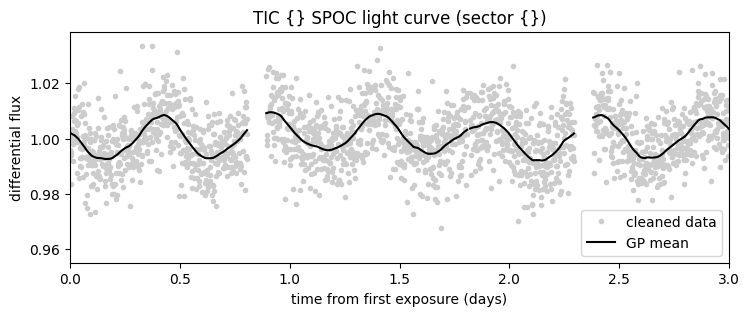

In [137]:
plt.figure(None, (8.5, 3))
plt.xlabel("time from first exposure (days)")
plt.ylabel("differential flux")
plt.title("TIC {} SPOC light curve (sector {})")
plt.plot(data["time"], data["flux"], ".", c="0.8", label="cleaned data")

gp_mean = mu(gp_params)
idxs = [0, *np.flatnonzero(np.diff(data["time"]) > 10 / 60 / 24)]
for i in range(len(idxs) - 1):
    x = data["time"][idxs[i] + 1 : idxs[i + 1]]
    y = gp_mean[idxs[i] + 1 : idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if i == 0 else None)
plt.legend()
plt.xlim(0, 3)


In [180]:
# Other things


def index_binning(x, size):
    if isinstance(size, float):
        bins = np.arange(np.min(x), np.max(x), size)
    else:
        x = np.arange(0, len(x))
        bins = np.arange(0.0, len(x), size)

    d = np.digitize(x, bins)
    n = np.max(d) + 2
    indexes = []

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            indexes.append(s)

    return indexes

In [206]:
n = 2000
idxs = index_binning(data["time"], n)
error = np.median(np.array([np.std(data["flux"][i]) for i in idxs])) / np.sqrt(n)


In [207]:
error


0.00022674976511111516

In [208]:
jitter


0.008907017815441565

In [179]:
np.split(data["flux"], len(data["time"]))


(array([9.72250570e-03, 2.98619809e-02, 4.93069905e-02, ...,
        2.02287431e+01, 2.02477067e+01, 2.02683263e+01]),
 array([0.99921958, 1.00495264, 0.99723686, ..., 0.9957962 , 0.99775278,
        0.99657135]))

In [ ]:
idxs


In [ ]:
idxs


In [ ]:
idxs


In [ ]:
import yaml

import astropy.units as u
import lightkurve as lk
import numpy as np
import pandas as pd

tic = 140212114

targets = pd.read_csv("../data/tess-ultra-fast-rotators-brighter-mag14.csv")[
    ["Name", "LS_Period", "Amplitude", "teff_val"]
]

targets = targets.sort_values("LS_Period")
target = targets[targets.Name == tic]

name = f"TIC {tic}"
search_result = lk.search_lightcurve(name, author="SPOC", exptime=120)

sector = search_result[0].mission[0].split(" ")[-1]
sector = int(sector.lstrip("0"))
info = {
    "tic": int(tic),
    "sector": int(sector),
    "ramsay_teff": float(target.teff_val.values[0]),
    "ramsay_period": float(target.LS_Period.values[0]),
}

In [ ]:
first_exposure = search_result[0].download().time[0]
time_format = f"{first_exposure.format} {first_exposure.scale}"
first_exposure_time = first_exposure.value


In [ ]:
sector = search_result[0].mission[0].split(" ")[-1]
# remove zeros before
sector = int(sector.lstrip("0"))


In [ ]:
sector
